# 8-Bit Autonomous Driving

In [336]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

![Sample](./images/driving_sample.gif)

## Review Training Data

Read in the training.csv data.  This is the data collected running the `01_training.py` file.


Column 0 = target value

In [337]:
from driver_util import show_road, get_training_data, direction
road_matrix, df = get_training_data("training.csv")
df.head()


,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,1,2,2,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,1,2,2,2,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,1,2,2,2,...,0,0,0,0,0,0,0,0,0,0


Review different samples, the road configuration at that row and the target value

[[0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0 0 0]]


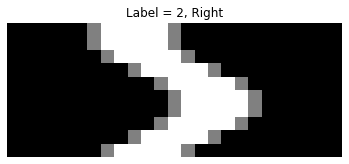

In [338]:
# 0 - offroad
# 1 - shoulder
# 2 - road
row = 33
show_road(road_matrix[row][1:], "Label = {}, {}".format(road_matrix[row][0], direction[road_matrix[row][0]]))

## Train a Machine Learning Model

Train a machine learning model on all 250 features to get a baseline accuracy before we reduce dimensions.

We will only use a LogisticRegression algorithm, however the `02_model_training.py` checks a number of models

In [339]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier


Create X, y variables

In [340]:
X = df.loc[:, 1:]
y = df.loc[:, 0]


In [341]:
X.shape

(150, 250)

In [342]:
y.shape

(150,)

Use cross_val_score to measure performance of model.  Note that the `02_model_training.py` script uses GridSearchCV to find the best parameters.

In [343]:
model = KNeighborsClassifier(n_neighbors=2, weights='distance')

In [344]:
cv_scores = cross_val_score(model, X, y, cv=5)
print(cv_scores, cv_scores.mean())


[0.83333333 0.9        0.86666667 0.9        0.86666667] 0.8733333333333334


# Reduce Dimensions with an AutoEncoder

In [345]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler

We need to decide on what the final dimension or number of columns we would like to reduce the dataset to.  

This is somewhat arbitrary and we should try a number of dimensions

In [346]:
min_dims = 32

In [347]:
input_size = X.shape[1]
layer_1 = 128
layer_2 = 64
layer_3 = 32
layer_last = min_dims



In [348]:
# Create Encoder
encoder = Sequential()
encoder.add(Dense(layer_1, input_shape=(input_size,), activation="relu"))
encoder.add(Dense(layer_2,activation="relu"))
encoder.add(Dense(layer_3,activation="relu"))
encoder.add(Dense(layer_last,activation="relu"))



In [349]:
# Create Decoder
decoder = Sequential()
decoder.add(Dense(layer_3, input_shape=(layer_last,), activation="relu"))
decoder.add(Dense(layer_2, activation="relu"))
decoder.add(Dense(layer_1, activation="relu"))
decoder.add(Dense(input_size, activation="relu"))


In [350]:
autoencoder = Sequential([encoder, decoder])
autoencoder.compile(loss="mse", optimizer=SGD(learning_rate=0.1))


Because we are not performing a traditional train/test split we are going to use all of the data to train the autoencoder.

In [351]:
encoder_scaler = MinMaxScaler()
X_scaled = encoder_scaler.fit_transform(X)

In [352]:
autoencoder.fit(X_scaled, X_scaled, epochs=2000)


Epoch 1/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.2153
Epoch 2/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.2131
Epoch 3/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.2106
Epoch 4/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.2076
Epoch 5/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.2042
Epoch 6/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.2003
Epoch 7/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.1957
Epoch 8/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.1905
Epoch 9/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.1847
Epoch 10/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.1786
Epoch 11/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.1726
Epoch 12/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.1668
Epoch 13/2000
5/5 [==============================

5/5 [==============================] - 0s 2ms/step - loss: 0.1224
Epoch 104/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.1222
Epoch 105/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.1219
Epoch 106/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.1216
Epoch 107/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.1214
Epoch 108/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.1211
Epoch 109/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.1209
Epoch 110/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.1206
Epoch 111/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.1204
Epoch 112/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.1200
Epoch 113/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.1198
Epoch 114/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.1195
Epoch 115/2000
5/5 [=======================

5/5 [==============================] - 0s 1ms/step - loss: 0.0797
Epoch 205/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0793
Epoch 206/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0790
Epoch 207/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0788
Epoch 208/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0785
Epoch 209/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0782
Epoch 210/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0779
Epoch 211/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0777
Epoch 212/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0774
Epoch 213/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0772
Epoch 214/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0769
Epoch 215/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0766
Epoch 216/2000
5/5 [=======================

5/5 [==============================] - 0s 2ms/step - loss: 0.0665
Epoch 306/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0665
Epoch 307/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0664
Epoch 308/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0664
Epoch 309/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0663
Epoch 310/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0663
Epoch 311/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0663
Epoch 312/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0662
Epoch 313/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0662
Epoch 314/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0661
Epoch 315/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0661
Epoch 316/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0661
Epoch 317/2000
5/5 [=======================

5/5 [==============================] - 0s 1ms/step - loss: 0.0630
Epoch 407/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0630
Epoch 408/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0629
Epoch 409/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0629
Epoch 410/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0629
Epoch 411/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0628
Epoch 412/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0628
Epoch 413/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0628
Epoch 414/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0628
Epoch 415/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0627
Epoch 416/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0627
Epoch 417/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0627
Epoch 418/2000
5/5 [=======================

5/5 [==============================] - 0s 1ms/step - loss: 0.0581
Epoch 508/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0581
Epoch 509/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0581
Epoch 510/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0581
Epoch 511/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0580
Epoch 512/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0580
Epoch 513/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0580
Epoch 514/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0580
Epoch 515/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0579
Epoch 516/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0579
Epoch 517/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0579
Epoch 518/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0579
Epoch 519/2000
5/5 [=======================

5/5 [==============================] - 0s 2ms/step - loss: 0.0564
Epoch 609/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0564
Epoch 610/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0564
Epoch 611/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0564
Epoch 612/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0563
Epoch 613/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0563
Epoch 614/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0563
Epoch 615/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0563
Epoch 616/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0563
Epoch 617/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0563
Epoch 618/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0563
Epoch 619/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0563
Epoch 620/2000
5/5 [=======================

5/5 [==============================] - 0s 2ms/step - loss: 0.0554
Epoch 710/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0554
Epoch 711/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0554
Epoch 712/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0554
Epoch 713/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0553
Epoch 714/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0554
Epoch 715/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0554
Epoch 716/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0553
Epoch 717/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0554
Epoch 718/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0553
Epoch 719/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0553
Epoch 720/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0553
Epoch 721/2000
5/5 [=======================

5/5 [==============================] - 0s 1ms/step - loss: 0.0547
Epoch 811/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0547
Epoch 812/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0547
Epoch 813/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0547
Epoch 814/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0547
Epoch 815/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0547
Epoch 816/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0547
Epoch 817/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0547
Epoch 818/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0547
Epoch 819/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0546
Epoch 820/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0546
Epoch 821/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0546
Epoch 822/2000
5/5 [=======================

5/5 [==============================] - 0s 1ms/step - loss: 0.0541
Epoch 912/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0541
Epoch 913/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0541
Epoch 914/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0541
Epoch 915/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0541
Epoch 916/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0541
Epoch 917/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0541
Epoch 918/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0540
Epoch 919/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0541
Epoch 920/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0541
Epoch 921/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0541
Epoch 922/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0541
Epoch 923/2000
5/5 [=======================

5/5 [==============================] - 0s 1ms/step - loss: 0.0536
Epoch 1013/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0536
Epoch 1014/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0536
Epoch 1015/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0536
Epoch 1016/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0536
Epoch 1017/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0535
Epoch 1018/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0535
Epoch 1019/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0536
Epoch 1020/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0535
Epoch 1021/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0536
Epoch 1022/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0535
Epoch 1023/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0535
Epoch 1024/2000
5/5 [===========

5/5 [==============================] - 0s 1ms/step - loss: 0.0531
Epoch 1113/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0531
Epoch 1114/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0531
Epoch 1115/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0531
Epoch 1116/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0531
Epoch 1117/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0531
Epoch 1118/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0531
Epoch 1119/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0530
Epoch 1120/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0530
Epoch 1121/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0531
Epoch 1122/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0530
Epoch 1123/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0530
Epoch 1124/2000
5/5 [===========

5/5 [==============================] - 0s 1ms/step - loss: 0.0526
Epoch 1213/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0526
Epoch 1214/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0526
Epoch 1215/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0526
Epoch 1216/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0526
Epoch 1217/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0526
Epoch 1218/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0525
Epoch 1219/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0526
Epoch 1220/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0525
Epoch 1221/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0526
Epoch 1222/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0525
Epoch 1223/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0525
Epoch 1224/2000
5/5 [===========

5/5 [==============================] - 0s 1ms/step - loss: 0.0521
Epoch 1313/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0521
Epoch 1314/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0521
Epoch 1315/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0521
Epoch 1316/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0521
Epoch 1317/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0521
Epoch 1318/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0521
Epoch 1319/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0521
Epoch 1320/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0521
Epoch 1321/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0521
Epoch 1322/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0521
Epoch 1323/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0521
Epoch 1324/2000
5/5 [===========

5/5 [==============================] - 0s 2ms/step - loss: 0.0517
Epoch 1413/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0517
Epoch 1414/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0517
Epoch 1415/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0516
Epoch 1416/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0517
Epoch 1417/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0516
Epoch 1418/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0516
Epoch 1419/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0517
Epoch 1420/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0516
Epoch 1421/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0516
Epoch 1422/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0516
Epoch 1423/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0516
Epoch 1424/2000
5/5 [===========

5/5 [==============================] - 0s 1ms/step - loss: 0.0513
Epoch 1513/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0513
Epoch 1514/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0513
Epoch 1515/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0513
Epoch 1516/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0513
Epoch 1517/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0512
Epoch 1518/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0512
Epoch 1519/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0513
Epoch 1520/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0512
Epoch 1521/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0512
Epoch 1522/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0513
Epoch 1523/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0512
Epoch 1524/2000
5/5 [===========

5/5 [==============================] - 0s 2ms/step - loss: 0.0509
Epoch 1613/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0509
Epoch 1614/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0509
Epoch 1615/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0509
Epoch 1616/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0509
Epoch 1617/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0509
Epoch 1618/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0509
Epoch 1619/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0509
Epoch 1620/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0509
Epoch 1621/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0509
Epoch 1622/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0509
Epoch 1623/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0509
Epoch 1624/2000
5/5 [===========

5/5 [==============================] - 0s 1ms/step - loss: 0.0506
Epoch 1713/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0506
Epoch 1714/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0505
Epoch 1715/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0506
Epoch 1716/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0505
Epoch 1717/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0506
Epoch 1718/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0506
Epoch 1719/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0505
Epoch 1720/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0506
Epoch 1721/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0505
Epoch 1722/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0505
Epoch 1723/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0506
Epoch 1724/2000
5/5 [===========

5/5 [==============================] - 0s 2ms/step - loss: 0.0502
Epoch 1813/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0503
Epoch 1814/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0502
Epoch 1815/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0502
Epoch 1816/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0502
Epoch 1817/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0502
Epoch 1818/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0503
Epoch 1819/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0502
Epoch 1820/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0503
Epoch 1821/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0503
Epoch 1822/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0502
Epoch 1823/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0502
Epoch 1824/2000
5/5 [===========

5/5 [==============================] - 0s 1ms/step - loss: 0.0499
Epoch 1913/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0500
Epoch 1914/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0500
Epoch 1915/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0500
Epoch 1916/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0500
Epoch 1917/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0499
Epoch 1918/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0499
Epoch 1919/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0499
Epoch 1920/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0499
Epoch 1921/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0499
Epoch 1922/2000
5/5 [==============================] - 0s 1ms/step - loss: 0.0499
Epoch 1923/2000
5/5 [==============================] - 0s 2ms/step - loss: 0.0499
Epoch 1924/2000
5/5 [===========

<AxesSubplot:>

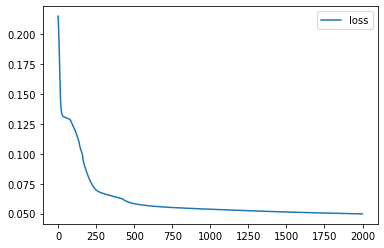

In [353]:
pd.DataFrame(autoencoder.history.history).plot()

## How we does the autoencoder do when reconstructing the road
display the output of the AutoEncoder

In [354]:
def show_autoencoder_results(sample_index):
    fig = plt.figure(figsize=(16,6))
    gs = fig.add_gridspec(1, 2)
    l_ax = fig.add_subplot(gs[0, 0])
    r_ax = fig.add_subplot(gs[0, 1])
    l_ax.imshow(X.iloc[sample_index].values.reshape((10,25)) * (255//2))
    decoded_road = autoencoder.predict(X.iloc[sample_index].values.reshape(1,250))
    print("Decoded Road 1 decimal")
    print(decoded_road.reshape((10,25)).round(1))
    print("Decoded Road rounded int")
    print(decoded_road.reshape((10,25)).astype(int))
    print("Original Road")
    print(X.iloc[sample_index].values.reshape((10,25)))
    
    r_ax.imshow(decoded_road.reshape((10,25)).round().astype(int) * (255//2))
    plt.show()

Decoded Road 1 decimal
[[0.  0.  0.  0.  0.  0.  0.  0.  2.1 2.1 0.  1.9 1.1 0.1 0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.9 1.9 2.1 2.1 2.1 1.9 1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.  1.8 2.1 0.  2.1 0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.1 1.  1.9 0.  2.1 2.  1.8 0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.9 0.  2.1 0.  1.8 1.9 0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.9 1.9 0.  2.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.9 0.  1.9 1.9 2.  2.
  1.2 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 1.5 1.9 1.9 1.9 1.8 1.2
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.1 0.  0.8 1.6 0.  1.9 2.  0.  1.2 0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.1 0.  1.7 1.

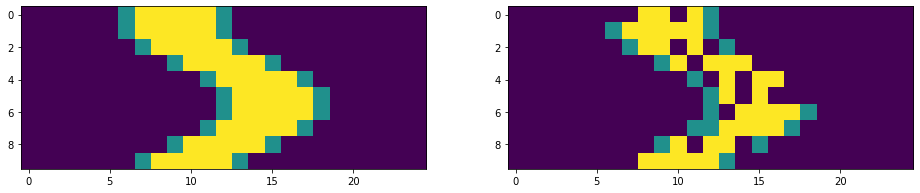

In [355]:
show_autoencoder_results(23)

Decoded Road 1 decimal
[[0.  0.  0.  0.  0.  0.  0.  0.  1.7 2.  0.  2.  1.7 1.1 0.2 0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.9 2.  2.1 2.  1.9 1.  0.2 0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.9 0.  2.2 2.  1.9 1.8 0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  2.  2.  2.1 2.  1.9 1.1 0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.7 1.9 2.1 2.1 1.9 1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.1 0.  0.9 1.7 0.  2.2 2.  1.8 1.1 0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.  2.  0.  1.9 1.  0.1 0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.9 1.7 1.8 1.9 2.  1.8 1.  0.1
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  2.  2.  0.  1.9 1.1 0.2
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.1 0.  0.1 0

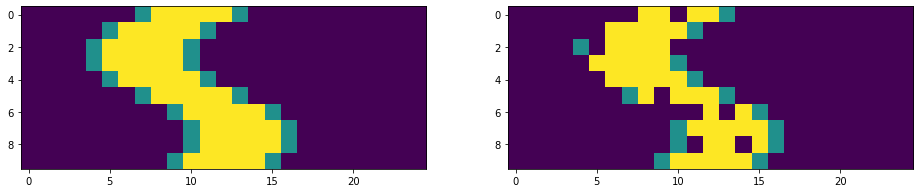

In [356]:
show_autoencoder_results(45)

Decoded Road 1 decimal
[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.2 1.9 2.  0.  0.  2.
  1.8 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.1 1.7 0.  1.9 2.3
  2.2 1.9 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.8 2.1 2.  2.1
  1.8 1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 1.  2.  2.2 0.  1.9 1.7
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.9 2.  2.1 0.  1.9 0.9 0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.1 1.1 0.  1.8 2.  2.1 1.9 0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.  1.8 0.  0.  0.  1.7 0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.1 0. ]
 [0.  0.  0.  0.  0.  0.  0.1 1.  1.8 1.9 1.9 1.8 1.6 0.8 0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.  1.9 1.8 0.  2.1 1.9 0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  

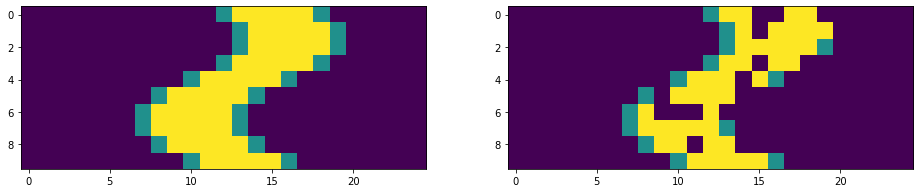

In [357]:
show_autoencoder_results(119)

## Use encoder to reduce dimensionality
Just use the encoder to reduce the dimensionality of the original dataset

In [358]:
X_scaled.shape

(150, 250)

In [359]:
# use encoder to compress or remove dimensionality
X_dim_reduced = encoder.predict(X_scaled)


In [360]:
X_dim_reduced.shape

(150, 32)

In [361]:
df_reduced = pd.DataFrame(X_dim_reduced)
df_reduced.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.0,0.0,3.007308,2.053643,2.906503,1.131570,1.482814,5.499528,6.566752,2.138178,...,0.0,4.889011,2.941307,0.464745,5.368271,4.081860,0.0,0.0,4.654847,3.176693
1,0.0,0.0,3.356261,0.593128,3.507797,0.485184,2.847719,3.581841,4.725641,1.314818,...,0.0,3.524978,2.571445,1.766656,4.899336,4.439191,0.0,0.0,5.349648,3.891504
2,0.0,0.0,3.778764,0.048365,3.973871,0.298655,3.872570,2.451039,3.552565,1.528522,...,0.0,2.353395,2.194962,3.293262,4.281917,4.457532,0.0,0.0,5.729420,4.075101
3,0.0,0.0,3.642645,0.384716,2.626943,0.065885,4.183852,0.909956,1.267835,2.564671,...,0.0,0.938297,1.588884,3.721878,3.803701,1.979021,0.0,0.0,4.220877,4.218796
4,0.0,0.0,3.361414,1.048771,1.824381,0.590684,4.434474,0.616335,0.241049,4.191222,...,0.0,0.138111,1.899973,3.336426,3.431776,0.104099,0.0,0.0,3.562394,4.119648


## Train a Machine Learning Model on new dataset

In [362]:
X_dim_reduced.shape

(150, 32)

In [363]:
y.shape

(150,)

In [364]:
model = KNeighborsClassifier(n_neighbors=2, weights='distance')
cv_scores = cross_val_score(model, X_dim_reduced, y, cv=5)
print(cv_scores, cv_scores.mean())




[0.83333333 0.9        0.86666667 0.86666667 0.86666667] 0.8666666666666668


In [365]:
results = [
    [1, 0.82],
    [2, 0.77],
    [4, 0.83],
    [8, 0.78],
    [16, 0.87],
    [32, 0.87],
    [64, 0.87],
    [128, 0.87],
    [1,0.75],
    [1,0.78],
    [1, 0.86],
    [4, 0.81],
    [4, 0.79],
    [4, 0.85],
    [16, 0.86],
    [16, 0.86],
    [8, 0.87]
    
]

In [366]:
df_results = pd.DataFrame(results, columns =['Dims', 'Accuracy'])

In [367]:
df_results

,Dims,Accuracy
0,1,0.82
1,2,0.77
2,4,0.83
3,8,0.78
4,16,0.87
5,32,0.87
6,64,0.87
7,128,0.87
8,1,0.75
9,1,0.78


In [368]:
print(df_results.groupby(['Dims'])[['Accuracy']].mean())

      Accuracy
Dims          
1     0.802500
2     0.770000
4     0.820000
8     0.825000
16    0.863333
32    0.870000
64    0.870000
128   0.870000
